### Data preparation
In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from (https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [94]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [95]:
df.shape

(1462, 9)

In [96]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

In [97]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [98]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [99]:
categoricals = df.dtypes[df.dtypes == 'object'].index.tolist()
categoricals

['lead_source', 'industry', 'employment_status', 'location']

In [100]:
numericals = df.dtypes[df.dtypes != 'object'].index.tolist()
numericals.remove('converted')
numericals

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [101]:
df[categoricals] = df[categoricals].fillna('NA')
df[numericals] = df[numericals].fillna(0.0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [102]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [103]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']
    
len(df), len(df_train), len(df_val), len(df_test)

(1462, 876, 293, 293)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [104]:
from sklearn.metrics import roc_auc_score
y = df_full_train['converted']
for variables in ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']:
    auc = roc_auc_score(y, df_full_train[variables])
    print(f'AUC for {variables}: {auc}')

AUC for lead_score: 0.6163611718677798
AUC for number_of_courses_viewed: 0.7578540402328948
AUC for interaction_count: 0.7276793690890606
AUC for annual_income: 0.5533332306460059


`number_of_courses_viewed` has the highest AUC

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [105]:
train_dict = df_train[categoricals + numericals].to_dict(orient='records')
train_dict[0]

{'lead_source': 'events',
 'industry': 'manufacturing',
 'employment_status': 'unemployed',
 'location': 'europe',
 'number_of_courses_viewed': 2,
 'annual_income': 95543.0,
 'interaction_count': 3,
 'lead_score': 0.78}

In [106]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_train.shape

(876, 31)

In [107]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [108]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [109]:
val_dict = df_val[categoricals + numericals].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val.shape

(293, 31)

In [110]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.57539503, 0.47060769, 0.61901236, 0.6143892 , 0.61741031,
       0.67496748, 0.8465351 , 0.38205016, 0.55735358, 0.91246751,
       0.77549359, 0.66110422, 0.91574386, 0.38389183, 0.88197523,
       0.89511778, 0.65336369, 0.53077648, 0.73106703, 0.70418456,
       0.78080321, 0.51381844, 0.88869813, 0.72195815, 0.91633086,
       0.53483932, 0.50123084, 0.84175873, 0.48497478, 0.60635462,
       0.63002389, 0.50197705, 0.54916065, 0.91861628, 0.6902664 ,
       0.65666092, 0.84766044, 0.79947504, 0.47461069, 0.63286015,
       0.82887379, 0.4355907 , 0.45453631, 0.58816791, 0.64477414,
       0.73619001, 0.53893927, 0.71596383, 0.74170518, 0.86747808,
       0.77685777, 0.75943833, 0.84663023, 0.67334212, 0.78059001,
       0.68835976, 0.63561826, 0.56955796, 0.6699862 , 0.75372267,
       0.33388224, 0.68155641, 0.35336533, 0.7745121 , 0.51403962,
       0.2620089 , 0.66844162, 0.41567479, 0.49375719, 0.54251895,
       0.85677057, 0.39794252, 0.46701359, 0.85106564, 0.77222

In [111]:
auc_val = roc_auc_score(y_val, y_pred)
round(auc_val, 3)

0.817

The AUC value is 0.817. The closest option from question #2 is `0.72`

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [112]:
import numpy as np
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores['precision'] = (df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])).fillna(0)
df_scores['recall'] = (df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])).fillna(0)
df_scores['diff_prec_recall'] = ((df_scores['precision'] - df_scores['recall']) < 0).astype(int)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,diff_prec_recall
0,0.00,171,122,0,0,0.583618,1.0,1
1,0.01,171,122,0,0,0.583618,1.0,1
2,0.02,171,122,0,0,0.583618,1.0,1
3,0.03,171,122,0,0,0.583618,1.0,1
4,0.04,171,122,0,0,0.583618,1.0,1


In [113]:
df_scores.isnull().sum()

threshold           0
tp                  0
fp                  0
fn                  0
tn                  0
precision           0
recall              0
diff_prec_recall    0
dtype: int64

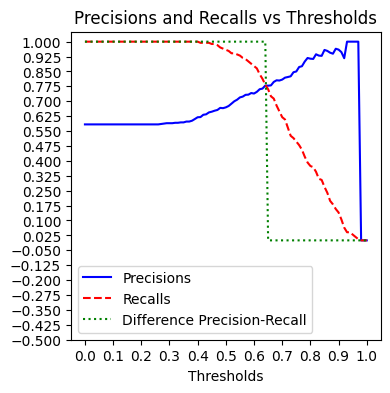

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))

plt.plot(df_scores['threshold'], df_scores['precision'], color='blue', linestyle='solid', label='Precisions')
plt.plot(df_scores['threshold'], df_scores['recall'], color='red', linestyle='dashed', label='Recalls')
plt.plot(df_scores['threshold'], df_scores['diff_prec_recall'], color='green', linestyle='dotted', label='Difference Precision-Recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(-0.5, 1, 21))

plt.xlabel('Thresholds')
plt.title('Precisions and Recalls vs Thresholds')

plt.show()

In [115]:
for i in range(1, len(df_scores)):
    if df_scores.iloc[i - 1]['diff_prec_recall'] != df_scores.iloc[i]['diff_prec_recall']:
        print(f'Precsion and recall curves intersect when threshold=`{df_scores.iloc[i]['threshold']:.3f}`')


Precsion and recall curves intersect when threshold=`0.650`


Precision and recall curves intersect when threshold=0.650. Hence, I choose the closest option `0.745`.

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [116]:
df_scores['f1_score'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])
df_scores['f1_score'].idxmax()

57

In [117]:
df_scores.iloc[df_scores['f1_score'].idxmax()]['threshold']

np.float64(0.5700000000000001)

F1 reached its maximum when threshold=0.57. Hence, I choose the closest option `0.54`.

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [118]:
from sklearn.model_selection import KFold
def k_fold_auc(df_full_train, categoricals, numericals, c=1.0):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    kf_auc = []
    for train_index, val_index in kf.split(df_full_train):
        # prepare train data
        df_train = df_full_train.iloc[train_index]
        train_dict = df_train[categoricals + numericals].to_dict(orient='records')
        y_train = df_train['converted'].values
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)

        # train the model
        X_train = dv.transform(train_dict)
        y_train = df_train['converted'].values
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
        
        # prepare validation data
        df_val = df_full_train.iloc[val_index]
        val_dict = df_val[categoricals + numericals].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_val = df_val['converted'].values

        # make predictions on validation data
        y_pred = model.predict_proba(X_val)[:, 1]

        # evaluate the model on validation data and store the AUC score in a list
        kf_auc.append(roc_auc_score(y_val, y_pred))
    
    return kf_auc

# calculate the standard deviation of the AUC scores
print(f'The standard deviation score of the kFold AUC:',{np.std(k_fold_auc(df_full_train, categoricals, numericals))})

The standard deviation score of the kFold AUC: {np.float64(0.03580711942905165)}


`0.06` is the closest option to the above result.

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [119]:
hyperparameters = [0.000001, 0.001, 1]
auc_score_hyperparamters = []

for c in hyperparameters:
    auc_score_hyperparamters.append(k_fold_auc(df_full_train, categoricals, numericals, c=c))

    print(f'hyperparameters: {c}, mean: {np.mean(auc_score_hyperparamters).round(3)}, std: {np.std(auc_score_hyperparamters).round(3)}')

hyperparameters: 1e-06, mean: 0.56, std: 0.024
hyperparameters: 0.001, mean: 0.714, std: 0.156
hyperparameters: 1, mean: 0.75, std: 0.139


`C=0.000001` achieves the lowerest mean of AUC score.